In [1]:
#__Date__:2017/05/19
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import seaborn
import matplotlib.pylab as plt
from shapely.geometry import Point
from shapely import geometry
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
with open('../data/cons.txt','r') as dt:
    data = dt.readlines()

data = pd.DataFrame(data[0].split(')'))

data.iloc[0,0] = ', '+data.iloc[0,0][1:]
data.iloc[1,0].split(',')[1]
data = data.drop(117)

data['dsf'] = data[0].apply(lambda x: x.split(',')[1])
data['count'] = data[0].apply(lambda x: x.split(',')[2])

data.dsf = data.dsf.apply(lambda x: x[3:-1])
data['count'] = data['count'].astype(int)

In [3]:
cons = pd.read_csv('../data/conswithloc.csv')

cons = pd.merge(cons, data, left_on= 'dsf_number_s_', right_on='dsf', how = 'right')
cons = cons.drop(['Unnamed: 0', 0], axis = 1)
cons = cons[cons['dsf'] != 'DSF:']

In [50]:
gp = cons.groupby('budget_label', as_index = False).sum()
gp.head()

,budget_label,count
0,0,383
1,1,327
2,2,280
3,3,3183


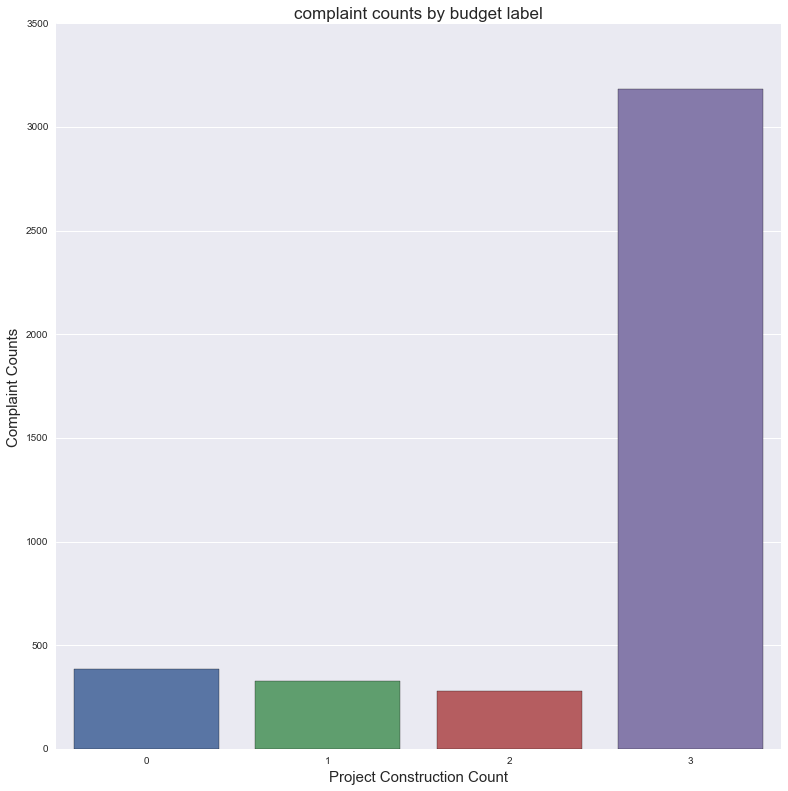

In [10]:
plt.figure(figsize=[13,13])
seaborn.barplot(x = 'budget_label', y = 'count', data = gp)
plt.ylabel('Complaint Counts', fontsize = 15)
plt.xlabel('Project Construction Count', fontsize = 15)
plt.title('complaint counts by budget label', fontsize = 17)
plt.savefig('../viz/complaint_counts_by_budget_level.png')

In [11]:
%store -r by_year

In [12]:
ct_shp = cons
ct_shp.geometry = map(lambda x: Point(float(x.split(' ')[1][1:]), float(x.split(' ')[2][:-1])), ct_shp.geometry)
ct_shp = gpd.GeoDataFrame(ct_shp, geometry = 'geometry')
ct_shp.crs = {u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

ct_shp.to_crs({'init': 'epsg:4326'})
ct_shp.project_phase_actual_end_date = map(lambda end: datetime.datetime.strptime(end[:19], '%Y-%m-%d %H:%M:%S'),\
                                          ct_shp.project_phase_actual_end_date)
ct_shp.project_phase_actual_start_date = map(lambda end: datetime.datetime.strptime(end[:19], '%Y-%m-%d %H:%M:%S'),\
                                          ct_shp.project_phase_actual_start_date)

In [13]:
min_start = ct_shp.project_phase_actual_start_date.min()
max_end = ct_shp.project_phase_actual_end_date.max()

print 'earliest start date of school project:', min_start
print 'latest end date of school project:', max_end

In [49]:
dtall = dtall[dtall.year>=2012] #constrain the noise complaints within this time range
dtall = dtall.drop(dtall[dtall.year == 2012][dtall.month < 5].index)

dtall.counts = dtall.counts.astype(int)
allsum = dtall.counts.sum()
cons2 = pd.read_csv('../data/construction.csv')

# The proportion of complaints caused by new school projects:

In [29]:
# over the city:
1.0 * data['count'].sum()/allsum

0.0022986510597378844

In [30]:
ct_bdr = gpd.read_file('../data/nyct2010_16d/nyct2010.shp')

# Since all school projects on the record are in Brooklyn, analyze Brooklyn Borough:

In [41]:
ct_bdr_bk = ct_bdr[ct_bdr.BoroName == 'Brooklyn']

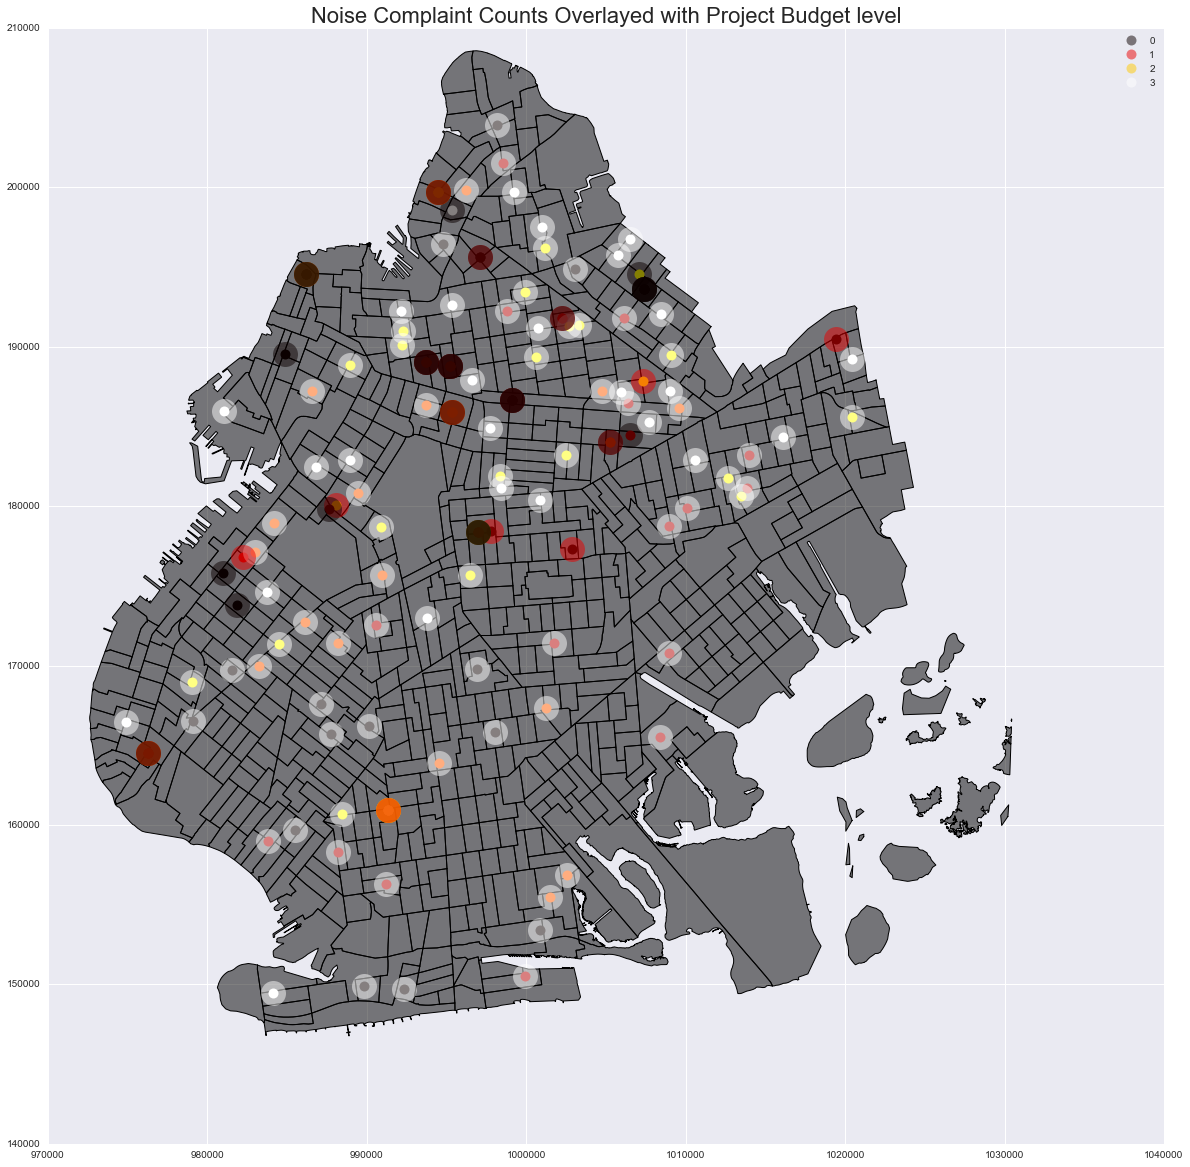

In [101]:
ax = ct_bdr_bk.plot( color = 'black', scheme = 'percentile',edgecolor = 'black', figsize=[20,20])
ct_shp.plot(column = 'count',cmap = 'hot', scheme = 'quantiles', ax = ax, markersize=10);
ct_shp.plot(column = 'budget_label',cmap = 'hot', ax = ax, alpha = .5, markersize=25, categorical=True, legend = True)


plt.legend(fontsize = 14)
plt.title('Noise Complaint Counts Overlayed with Project Budget level', fontsize = 22)
plt.savefig('../viz/1_CompCount_Budget_map.png',bbox_inches='tight')

# There's an overlay between budget level and complaint counts shown on the map - try with numerical analysis to find the overlay

In [106]:
# categorize complaint counts into four bins, just as budget levels
ct_shp['count_level'] = pd.qcut(ct_shp['count'], q = [0, .25, .5, .75, 1.], labels = [0, 1, 2, 3])

In [113]:
ct_shp['bud_ct_diff'] = np.abs(ct_shp['count_level'] - ct_shp['budget_label'])

In [140]:
sz = ct_shp.groupby('bud_ct_diff', as_index=False, group_keys=False).count()

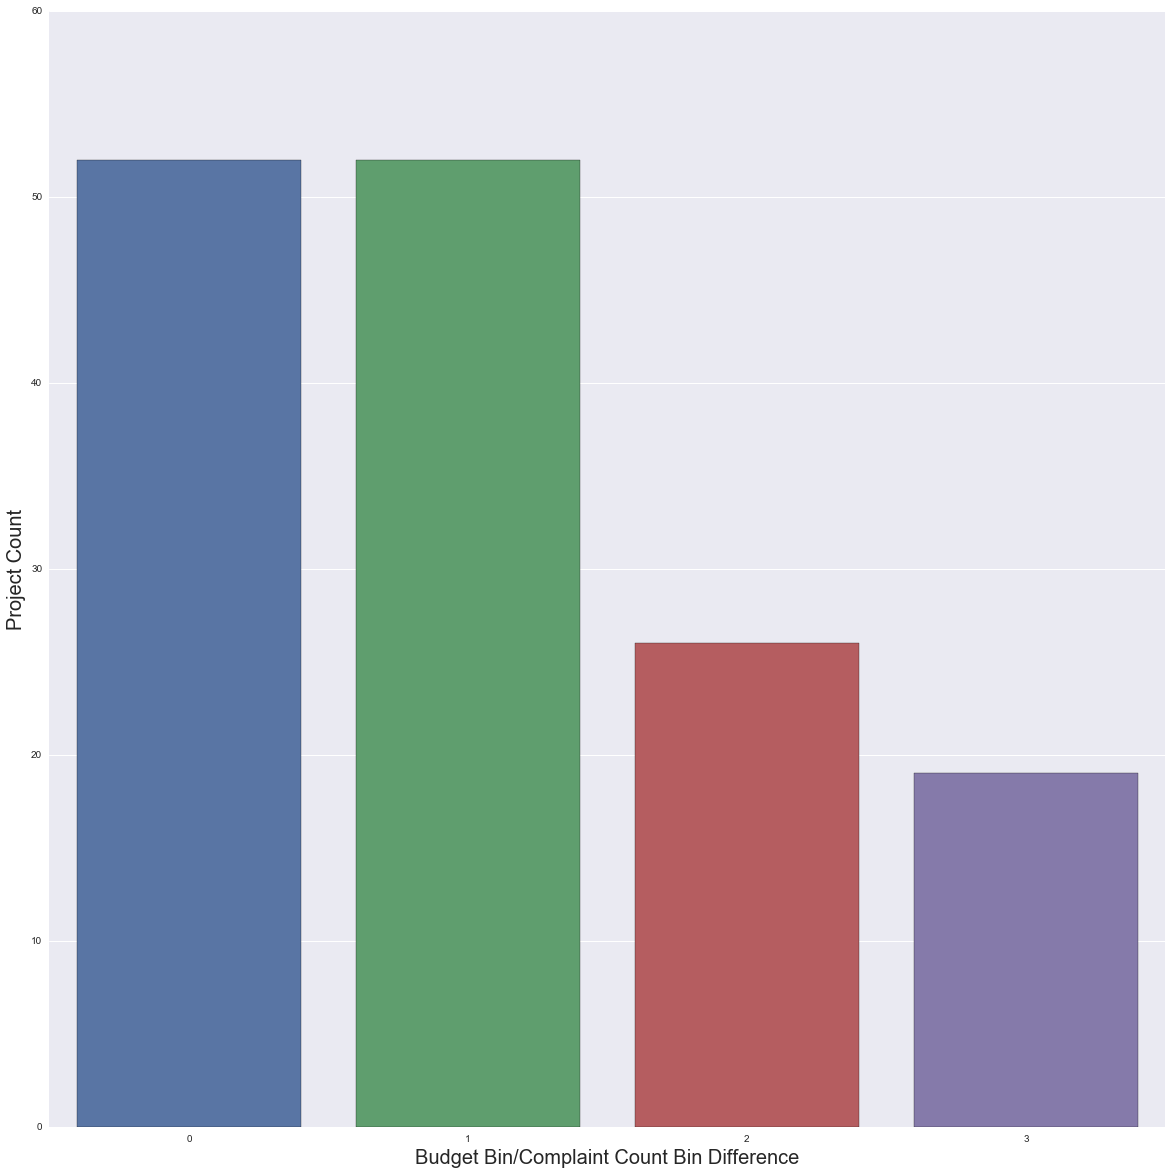

In [145]:
plt.figure(figsize = [20,20])
seaborn.barplot(x = 'bud_ct_diff', y = 'dsf_number_s_', data = sz)
plt.xlabel('Budget Bin/Complaint Count Bin Difference', fontsize = 20)
plt.ylabel('Project Count', fontsize = 20)
plt.savefig('../viz/proj_budget_complaint_diff_rlt_barplot.png')

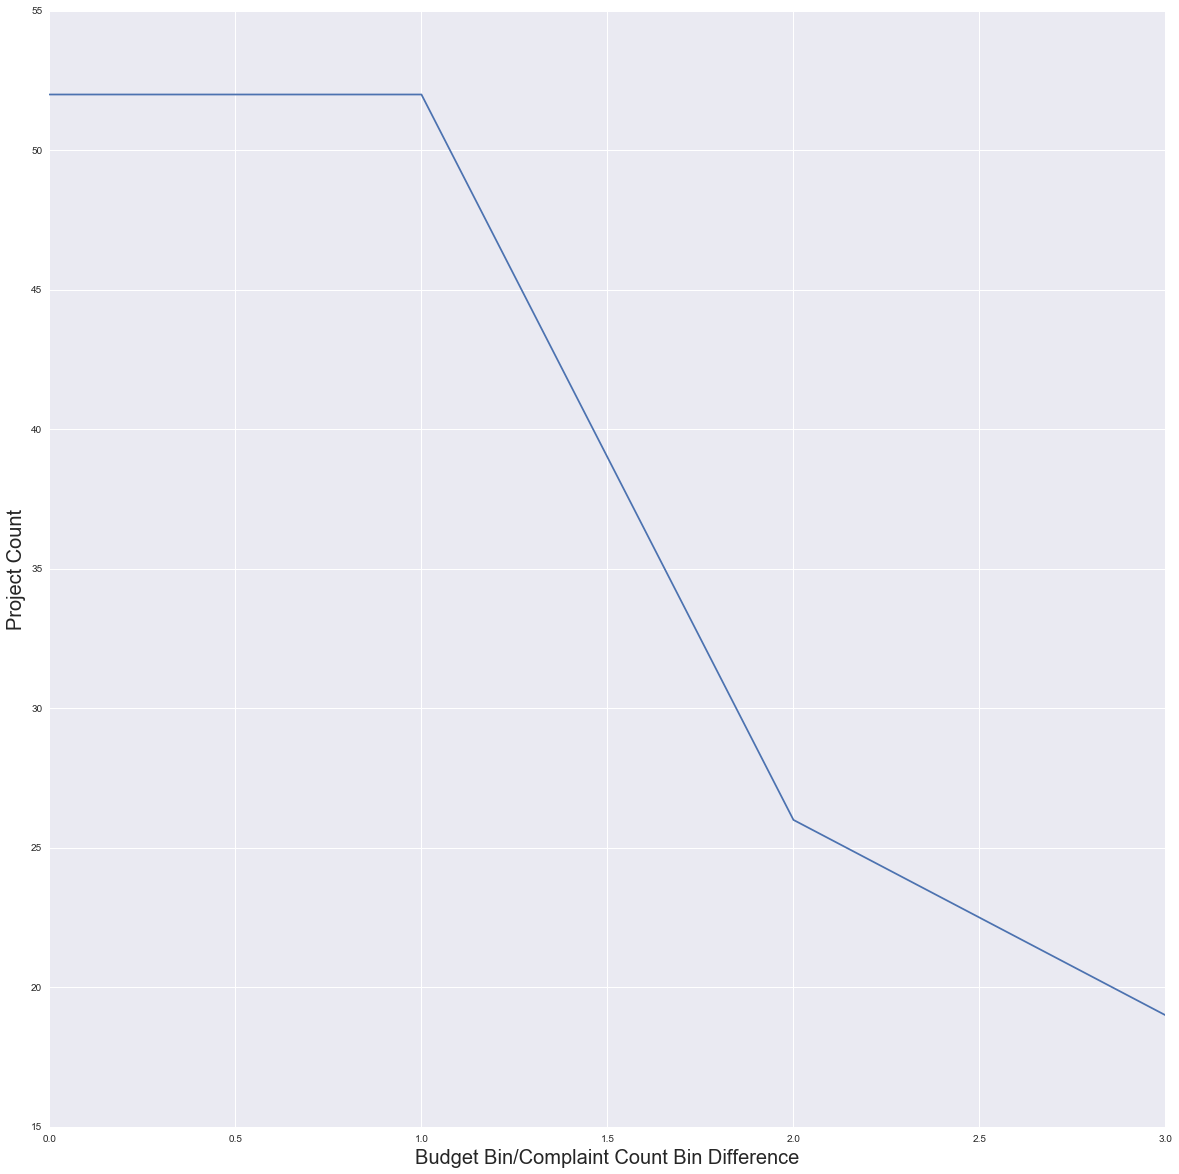

In [148]:
plt.figure(figsize = [20,20])
plt.plot(sz.dsf_number_s_)
plt.xlabel('Budget Bin/Complaint Count Bin Difference', fontsize = 20)
plt.ylabel('Project Count', fontsize = 20)
plt.savefig('../viz/proj_budget_complaint_diff_rlt_plot.png')